## **_REINFORCEMENT Agent_ para el ambiente _Lunar Lander_**

### **Importando dependencias**

In [2]:
!pip install box2d-py
!pip install gym[Box_2D]
import gym

     |████████████████████████████████| 450kB 17.1MB/s 


In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### **Acceder a los directorios de _drive_**

In [4]:
from google.colab import drive

In [ ]:
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/My Drive/DATASETS"

### **Modelo de red neuronal**

In [34]:
class DNN(nn.Module):
    def __init__(self, stateSize, actionSize, hidden=256):
        super(DNN, self).__init__()
        # definiendo las capas del modelo
        self._l1 = nn.Linear(stateSize, hidden)
        self._l2 = nn.Linear(hidden, actionSize)

    def forward(self, x):
        x = F.relu(self._l1(x))
        x = self._l2(x)
        x = F.softmax(x, dim=0)
        return x

### **Agente**

In [61]:
class REINFORCEAgent:
  def __init__(self, environment):
    # resguardamos el ambiente
    self._env = environment
    self._stateSize  = self._env.observation_space.shape[0]
    self._actionSize = self._env.action_space.n
    # generamos el modelo de NN
    self._model = DNN(stateSize=self._stateSize, actionSize=self._actionSize)
    # otros parametros
    self._gamma = 0.95
    self._lr = 0.003
    self._optimizer = torch.optim.Adam(self._model.parameters(), self._lr)


  def learn(self, trajectories, horizon):
    score = list()

    for trajectory in range(trajectories):
      transitions = list()
      batchGvals = list()

      done  = False
      state = self._env.reset()

      for h in range(horizon):
        actProb = self._model(torch.from_numpy(state).float())
        action  = np.random.choice(np.array([0, 1, 2, 3]), p=actProb.data.numpy())
        prevState = state
        state, _, done, info = self._env.step(action) 
        transitions.append((prevState, action, h + 1)) 
        if done: 
            break

      score.append(len(transitions))
      rewardBatch = torch.Tensor([reward for (state, action ,reward) in transitions]).flip(dims=(0,))

      for i in range(len(transitions)):
          newGval, power = 0, 0
          for j in range(i, len(transitions)):
              newGval = newGval+((self._gamma**power)*rewardBatch[j]).numpy()
              power += 1
          batchGvals.append(newGval)
      expectedReturnsBatch = torch.FloatTensor(batchGvals)

      expectedReturnsBatch /= expectedReturnsBatch.max()
      stateBatch  = torch.Tensor([state  for (state, action ,reward) in transitions]) 
      actionBatch = torch.Tensor([action for (state, action ,reward) in transitions]) 

      predBatch = self._model(stateBatch) 
      probBatch = predBatch.gather(dim=1, index=actionBatch.long().view(-1,1)).squeeze()

      loss = -torch.sum(torch.log(probBatch) * expectedReturnsBatch) 
      
      self._optimizer.zero_grad()
      loss.backward()
      self._optimizer.step()

      if trajectory%50 == 0 and trajectory > 0:
              print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

    return score


  def _watchAgent(self, timesteps):
    rewards = list()
    state = self._env.reset()
    
    for t in range(timesteps):
      pred = self._model(torch.from_numpy(state).float())
      action = np.random.choice(np.array([0, 1, 2, 3]), p=pred.data.numpy())
      state, reward, done, _ = self._env.step(action)
      rewards.append(reward)
      if done:
          break 
    self._env.close()
    return sum([reward for reward in rewards])


  def run(self, episodes, timesteps):
    rewards = list()
    for episode in range(episodes):
        rewards.append(self._watchAgent(timesteps))

    return rewards

In [62]:
agent = REINFORCEAgent(environment=gym.make('LunarLander-v2'))

In [63]:
score = agent.learn(trajectories=500, horizon=500)
print('training finished:')

Trajectory 50	Average Score: 92.84
Trajectory 100	Average Score: 96.92
Trajectory 150	Average Score: 95.37
Trajectory 200	Average Score: 123.02
Trajectory 250	Average Score: 163.59
Trajectory 300	Average Score: 181.41
Trajectory 350	Average Score: 144.57
Trajectory 400	Average Score: 136.92
Trajectory 450	Average Score: 156.41
training finished:


### **Métricas de desempeño**

In [64]:
def computeMean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [76]:
score = np.array(score)
means = computeMean(score)

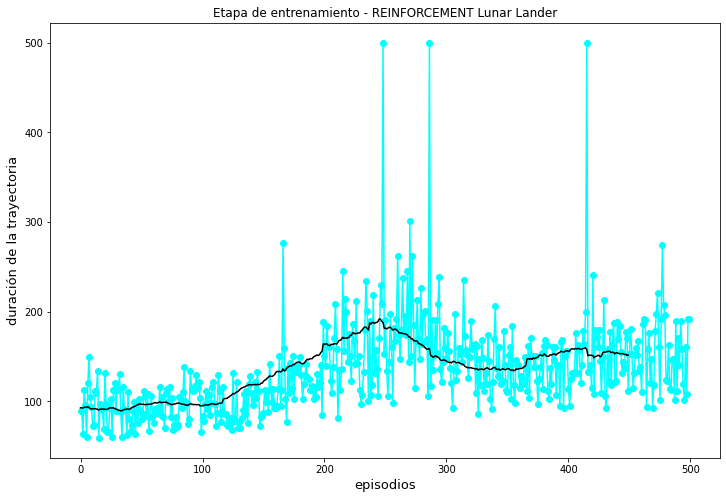

In [79]:
fig = plt.figure()
fig.set_size_inches(12, 8)

plt.ylabel("duración de la trayectoria", fontsize=13)
plt.xlabel("episodios", fontsize=13)
plt.plot(score, color='cyan')
plt.scatter(np.arange(score.shape[0]), score, color='cyan')
plt.plot(means, color='black')
plt.title('Etapa de entrenamiento - REINFORCEMENT Lunar Lander')
plt.show()

### **Observar al agente en acción**

In [81]:
rewards = agent.run(episodes=200, timesteps=2000)

In [83]:
means = [0] + [sum(rewards[:num])/num for num in range(1, len(rewards))]
steps = [num for num, val in enumerate(rewards)]

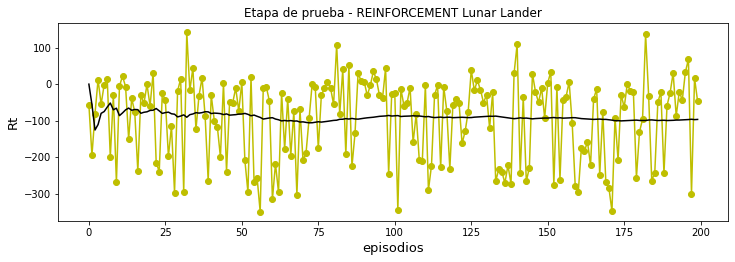

In [84]:
fig = plt.figure()
fig.set_size_inches(12, 8)
ax1 = fig.add_subplot(211)

ax1.plot(steps, rewards, '-oy', steps, means, '-k')
ax1.set_title('Etapa de prueba - REINFORCEMENT Lunar Lander')
ax1.set_ylabel('Rt', fontsize=13)
ax1.set_xlabel('episodios', fontsize=13)

plt.show()